# Colony Image processing
##  From stacked tif images to angular and pair correlation metric

#### Import used packages

In [7]:
using Pkg
Pkg.activate(@__DIR__) 
Pkg.instantiate()

  Activating project at `c:\Users\Andreas\Dropbox\phd\Image analysis\ColonyImages`


In [8]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization
import ColorSchemes as co 

#### Create empty data frame to store metrics together with colony ids and age of colony  

In [9]:
df = DataFrame(data_set =String[], colony = String[], time = Int[], 
    metric_OG =Vector{Vector{Int64}}(undef,0), metric_cov = Vector{Vector{Int64}}(undef,0),
    pair_OG =Vector{Vector{Int64}}(undef,0),pair_cov =Vector{Vector{Int64}}(undef,0),
    OG_size = Int[], border_points =Vector{Vector{CartesianIndex{2}}}(undef,0), Parameters = Vector{parameters}(undef,0))

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…


#### Check which data sets are available in data folder

In [10]:
image_data = "data\\image_data_stacked\\"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  10_04_23_stacked_half_res
2  14_06_23_stacked_full_res
3  14_06_23_stacked_half_res
4  17_05_23_stacked_full_res
5  17_05_23_stacked_half_res
6  19_12_22_stacked_full_res
7  26_06_23_stacked_full_res
8  27_04_22_stacked_full_res_expo
9  27_04_22_stacked_half_res_expo
10  28_03_23_stacked_half_res


#### Chose dataset 
Image pipeline has been created for stacked tif images. Image data needs to be in that format for pipeline to work correctly.  

In [97]:
data_set = readdir(image_data)[10]
path = joinpath(image_data, data_set)
readdir(path)

14-element Vector{String}:
 "Kolonie 1.tif"
 "Kolonie 2.tif"
 "Kolonie 3.tif"
 "Kolonie 4.tif"
 "Kolonie 5.tif"
 "Kolonie 6.tif"
 "Kolonie 7.tif"
 "Kolonie 8.tif"
 "angular&pair.png"
 "methos_compare_centroid.png"
 "methos_compare_cov.png"
 "methos_compare_cov_shown.png"
 "show_cov.png"
 "timepoints.csv"

The time series colony images have been take at certain dates/times T(n) (where n is the number of time points). The specific dates can be found in the meta data of the raw tif images. Here only the relative time points are relevant, therefore first images are set to T_r(1) = 0 and the following to the next full hours of T(n)_r = T(n)-T(1). The time points are stored in a `csv` file called `timepoints.csv` next to the image data. If `timepoints.csv` does not exist already, it will be created manually by the cell below. 

In [98]:
if "timepoints.csv" ∉ readdir(path)
    
    df2 = DataFrame(time = Float64[0,20,24,44])
    
    if length(df2.time) != size(load(joinpath.(path, filter(x->x[end-2:end]=="tif",readdir(path)))[1]))[3]
        println("ERROR ERROR ERROR ")
    else
        CSV.write(joinpath(path,"timepoints.csv"), df2)   
    end
else println("df already existing")
end

time_points = CSV.read(joinpath(path,"timepoints.csv"), DataFrame).time

df already existing


4-element Vector{Float64}:
  0.0
  5.0
 24.0
 48.0

All `tif` files inside chosen folder are loaded into img_vec with is a vector of stacked images(3 dimensional (x,y,t) arrays). 

In [99]:
colonies = filter(x->x[end-2:end]=="tif",readdir(path))
img_vec  = load.(joinpath.(path, colonies));

In [100]:
img_int_vec = b_w.(img_vec);

para = parameters(
        im_size = [size(img_int_vec[1])[1:2]...],
        time_points = time_points,
        colony_nr = length(img_int_vec),
        colonies = colonies,
        threshold_conv = 0.8);

plot_sim = false
Points= lattice_points(Int(maximum(para.im_size)÷2))
#fill holes in binary image
img_int_vec = fill_holes.(img_int_vec,[para.relative_size_filles_holes for x in length(img_int_vec)]);

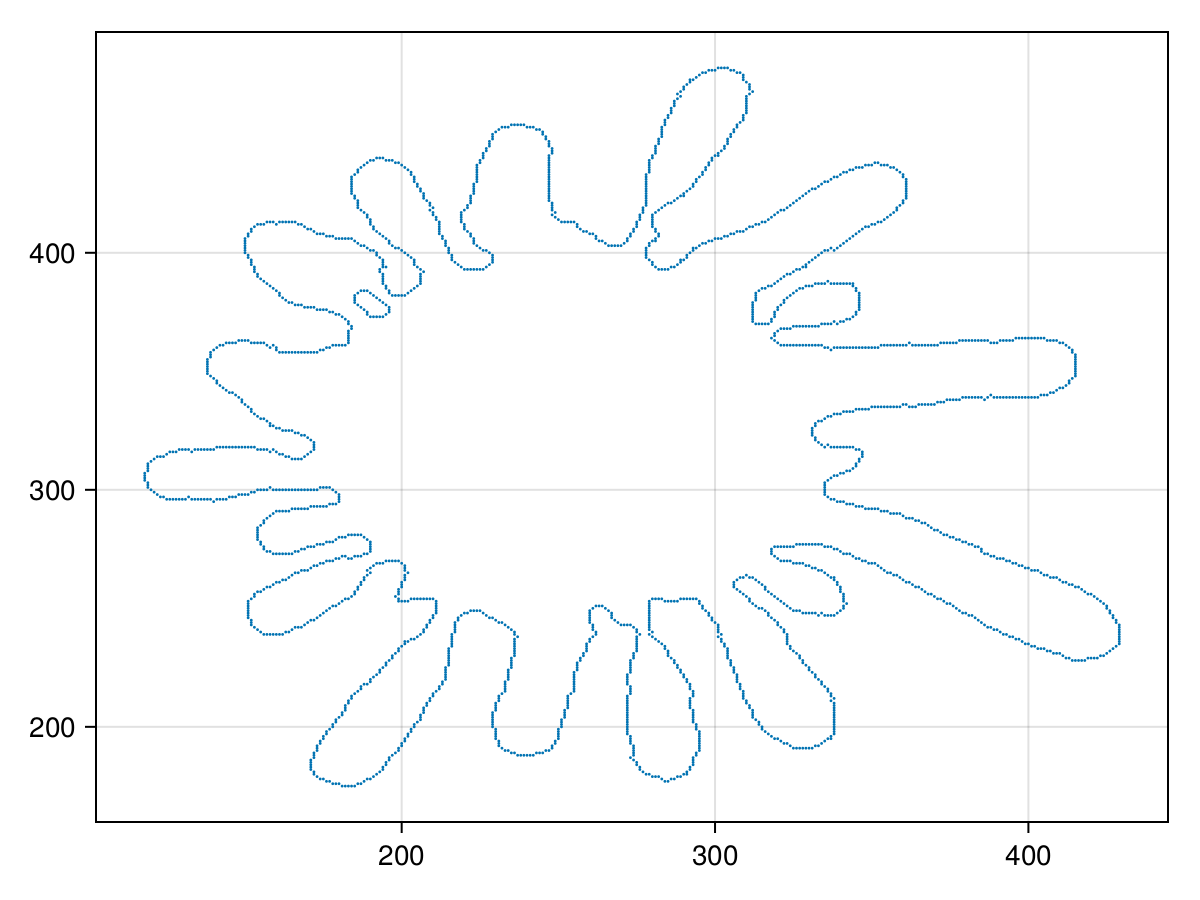

In [101]:
img2 = img_int_vec[3][:,:,3]
border_points = find_boundary_points(img2)
border_points_p = [Point2f(x[1],x[2]) for x in border_points]
scatter(border_points_p, markersize = 2)

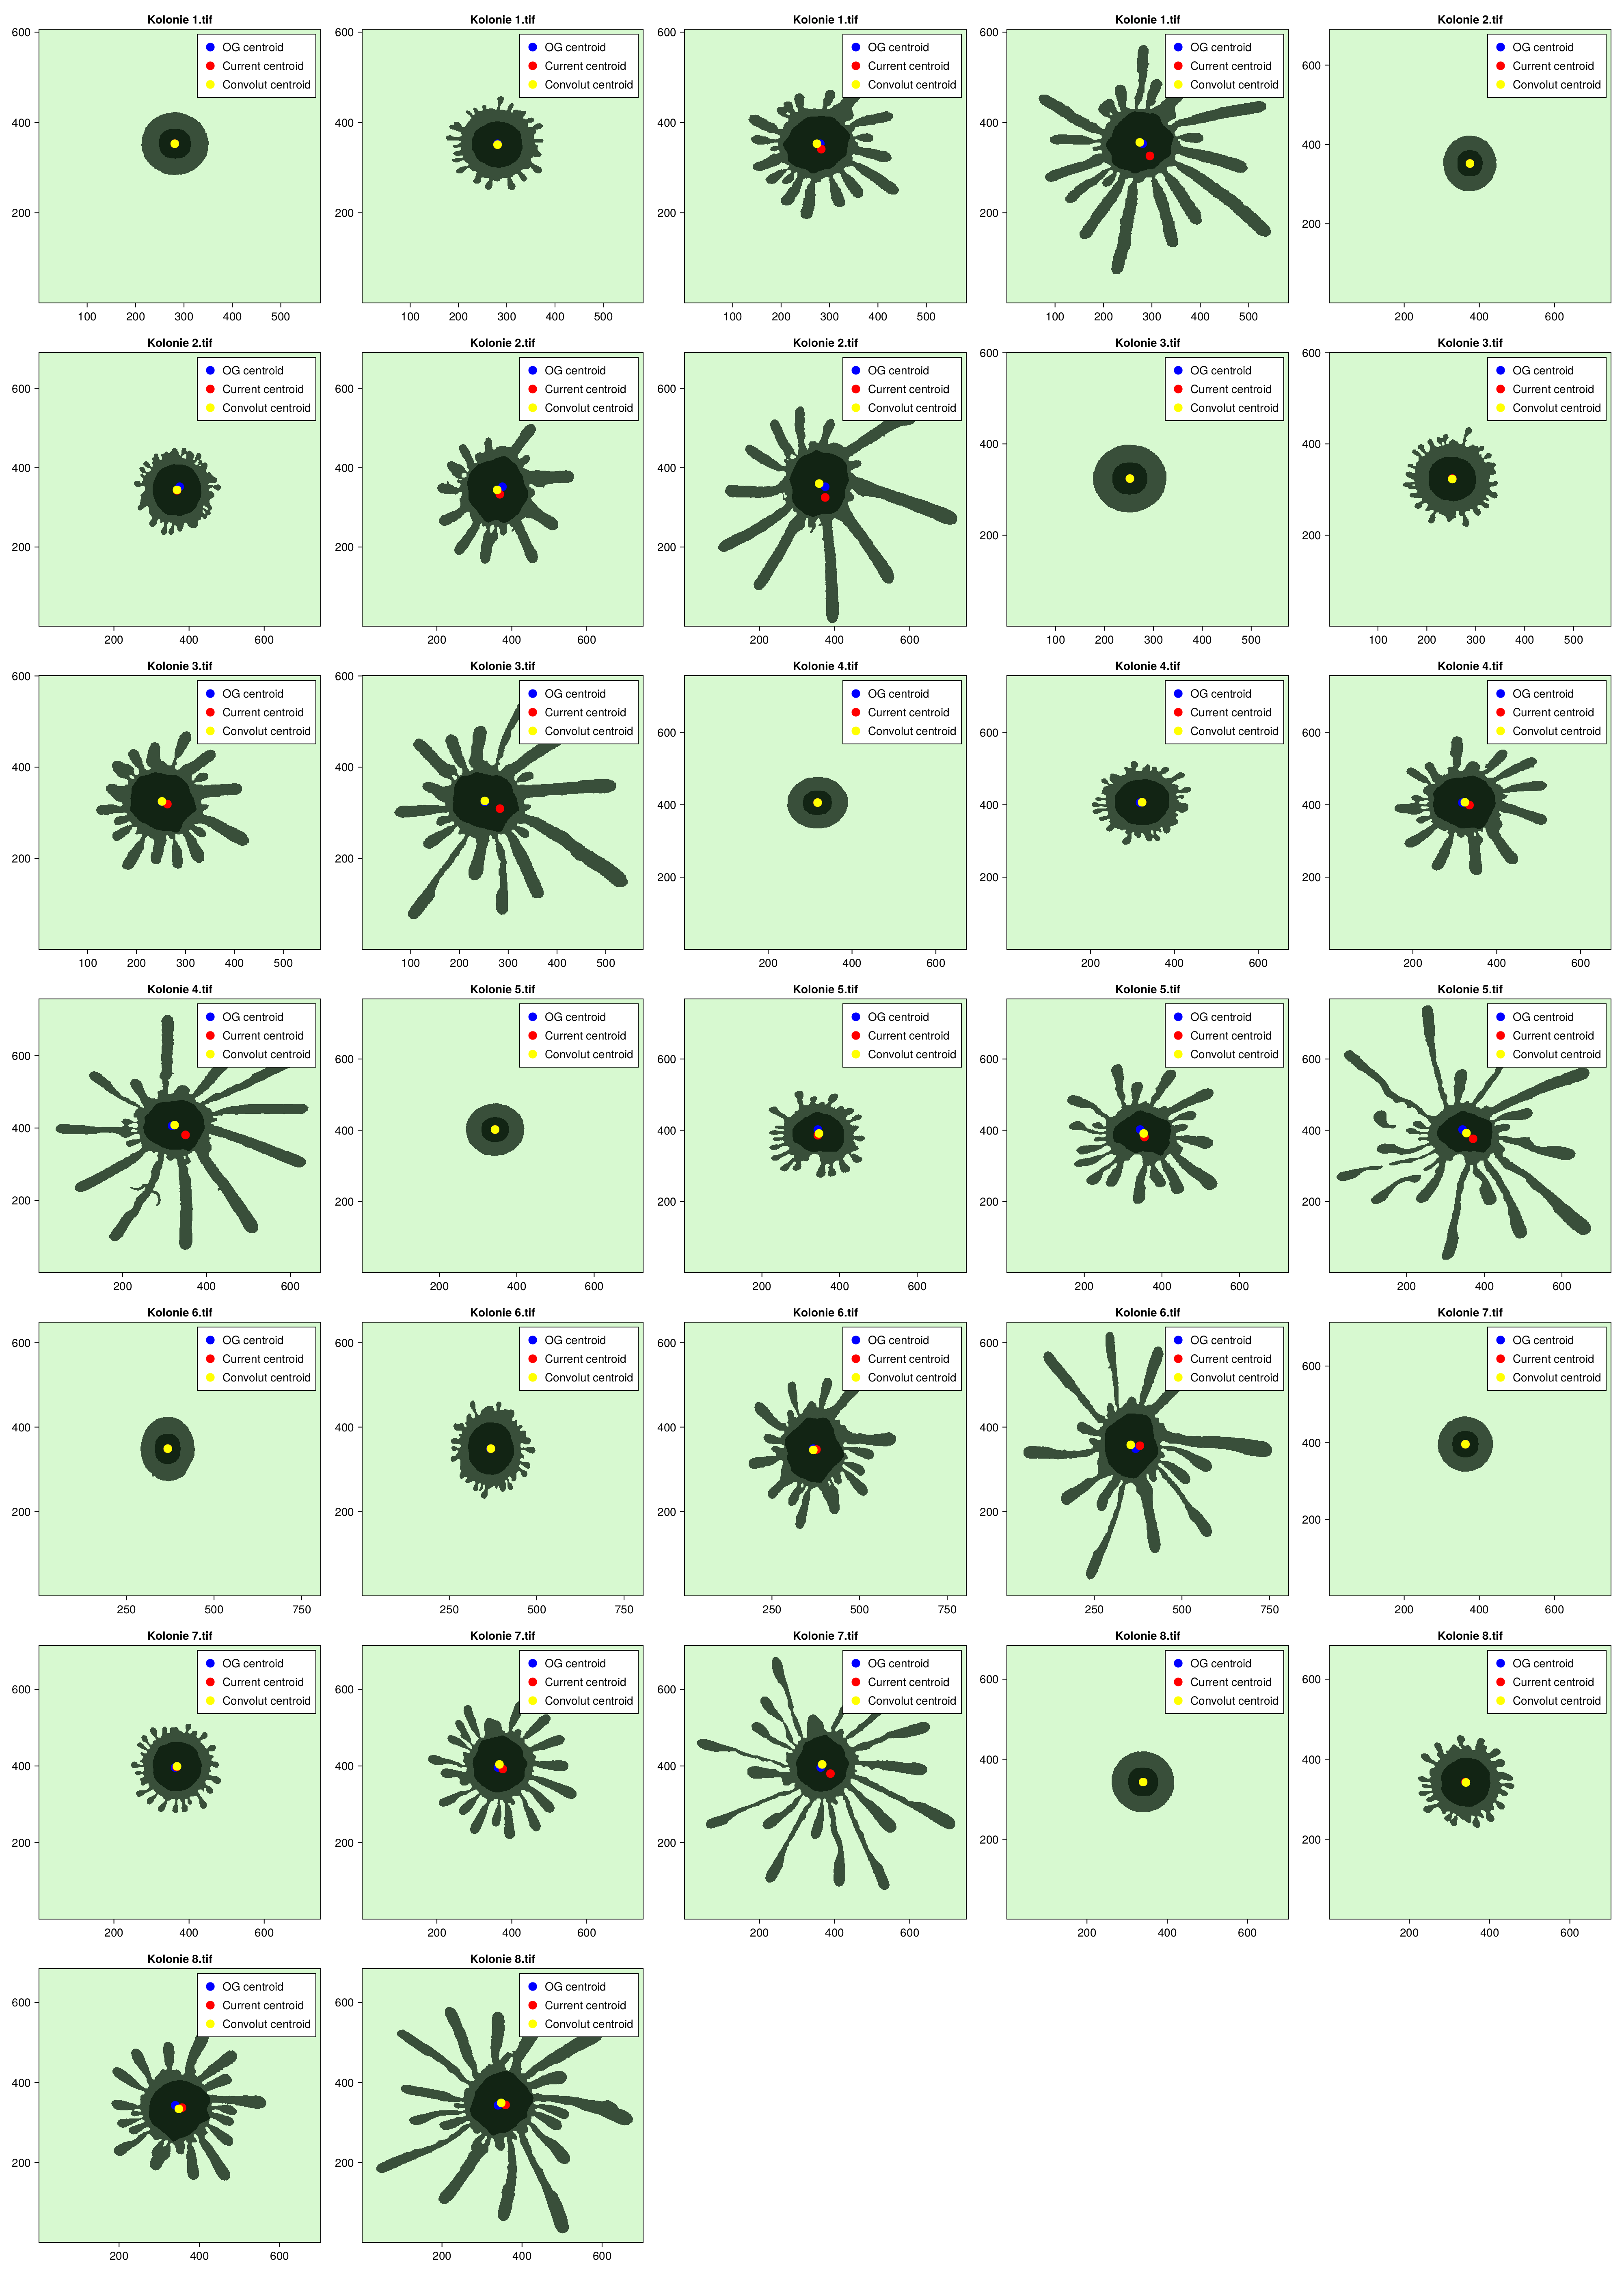

In [102]:
fig_test = plot_time_series_cov_centroid(img_int_vec, para)

In [103]:
data_set_name = save_time_series_metrics!(img_int_vec, para,df,Points, name_data = data_set)

"28_03_23_stacked_half_res 2024_04_16"

In [104]:
first(df)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…
1,10_04_23_stacked_half_res 2024_04_16,Kolonie 1.tif,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[16, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 16]","[5702, 4707, 5277, 5701, 5619, 5476, 5485, 5498, 5869, 5366 … 5458, 5857, 5628, 5512, 5554, 5558, 5920, 5346, 4664, 6433]","[5727, 4594, 5200, 5573, 5727, 5404, 5659, 5419, 5819, 5432 … 5301, 5699, 5597, 5677, 5464, 5710, 5799, 5233, 4801, 6400]",2992,"CartesianIndex{2}[CartesianIndex(135, 131), CartesianIndex(136, 131), CartesianIndex(137, 131), CartesianIndex(138, 131), CartesianIndex(139, 131), CartesianIndex(140, 131), CartesianIndex(141, 131), CartesianIndex(142, 131), CartesianIndex(143, 131), CartesianIndex(131, 132) … CartesianIndex(146, 191), CartesianIndex(147, 191), CartesianIndex(135, 192), CartesianIndex(136, 192), CartesianIndex(137, 192), CartesianIndex(138, 192), CartesianIndex(139, 192), CartesianIndex(140, 192), CartesianIndex(141, 192), CartesianIndex(142, 192)]","parameters([0.0, 24.0, 48.0], 0.8, 0.8, 0.4, 360, 2000000, 300, [318, 324], 3, 16, [159, 162], 0.029717, #5, 0.01, [0 1 0; 1 -4 1; 0 1 0], 8, [""Kolonie 1.tif"", ""Kolonie 2.tif"", ""Kolonie 3.tif"", ""Kolonie 4.tif"", ""Kolonie 5.tif"", ""Kolonie 6.tif"", ""Kolonie 7.tif"", ""Kolonie 8.tif""], 2.0, [0.0, 1.01943, 3.07811], [1.01943, 2.05867], 15, 0.1, #7, 0.2, 0.995, 0.995)"


In [106]:
unique(df.data_set)

10-element Vector{String}:
 "10_04_23_stacked_half_res 2024_04_16"
 "14_06_23_stacked_full_res 2024_04_16"
 "14_06_23_stacked_half_res 2024_04_16"
 "17_05_23_stacked_full_res 2024_04_16"
 "17_05_23_stacked_half_res 2024_04_16"
 "19_12_22_stacked_full_res 2024_04_16"
 "26_06_23_stacked_full_res 2024_04_16"
 "27_04_22_stacked_full_res_expo 2024_04_16"
 "27_04_22_stacked_half_res_expo 2024_04_16"
 "28_03_23_stacked_half_res 2024_04_16"

In [107]:
name_of_sim = "data_sets_10_"
path_metric = joinpath("data", "metrics")

"data_sets_10_"

In [109]:
serialize(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).jls"),df)
CSV.write(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).csv"),df)

"data\\metrics\\data_sets_10_2024_04_16.csv"